<a href="https://colab.research.google.com/github/girinath18/Driving-Licence-Detection/blob/main/DreamBooth_Stable_Diffusion_SDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-click execution of Dreambooth Stable Diffusion
- Jan 5, 2024  - Display images individually in 2nd cell.
- Dec 25, 2023 - Fixed bug not saving model if folder not exist.
- Dec 24, 2023 - Updated sampler to Euler to remove warning.
- Dec 21, 2023 - Updated diffusers to the current version.
- Dec 14, 2023 - Fixed bitsandbytes import error.


Tutorials and prompts at [stable-diffusion-art.com](https://stable-diffusion-art.com)

The latest copy can be found [here](https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb).


See the [Dreambooth tutorial](https://stable-diffusion-art.com/dreambooth/) for a step-by-step guide. Leave comment under article if you have any questions.



In [ ]:
import time

#@title DreamBooth
HUGGINGFACE_TOKEN = ""

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "SG161222/Realistic_Vision_V2.0" #@param {type:"string"}
BRANCH = "main" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "photo of a Anjalina jolie woman" #@param {type:"string"}
class_prompt =  "photo of a woman" #@param {type:"string"}
training_steps = 300 #@param {type:"integer"}
learning_rate = 5e-6 #@param {type:"number"}
output_file = "AI_PICS/models/my_dreambooth_model.safetensors" #@param {type:"string"}
#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}

#@markdown Clear log after run?
CLEAR_LOG = False #@param {type:"boolean"}

# Mount google drive for saving the model
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/output"
INSTANCE_DIR = "/content/data/instance"
CLASS_DIR = "/content/data/class"
!mkdir -p $INSTANCE_DIR
!mkdir -p $CLASS_DIR

!rm -rf $OUTPUT_DIR
!mkdir -p $OUTPUT_DIR

if 'pipe' in locals():
  del pipe

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Upload training images.
import os
from google.colab import files
import shutil
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

time_start = time.time()
def clear():
    from IPython.display import clear_output; return clear_output()

# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install diffusers
!git clone https://github.com/sagiodev/diffusers.git #https://github.com/huggingface/diffusers.git
%cd diffusers
!git checkout 08b453e3828f80027d881bb460716af95e192bcd -- ./scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install .


# install dreambooth
%cd /content/diffusers/examples/dreambooth
%pip install -r requirements.txt
%pip install bitsandbytes #xformers torch==2.1.0+cu121 # gradio natsort safetensors xformers torch==2.1.0+cu121 accelerate
!accelerate config default


# test bitsandbytes
import bitsandbytes
import torch
print(torch.__version__)

# Dreambooth training - Edit this section to customize parameters
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --revision=$BRANCH \
  --instance_prompt="$instance_prompt" \
  --class_prompt="$class_prompt" \
  --class_data_dir=$CLASS_DIR \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps

#  --enable_xformers_memory_efficient_attention \

########################################
#prompt = "photo of zwx"
prompt = instance_prompt
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline,EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np



if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None




g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    fig=figure(figsize=(5*num_samples,5*num_samples))
    for i in range(num_samples):
        a=fig.add_subplot(1, num_samples,i+1)
        imshow(images[i])
        axis('off')


######################################
# Save to checkpoint file
ckpt_path = '/content/drive/MyDrive/' + output_file
# save model file. Save to a new name if already exist.
dirname= os.path.dirname(ckpt_path)
!mkdir -p $dirname
filename = os.path.basename(ckpt_path)
fileanmeWithoutExt = os.path.splitext(filename)[0]
ExtName = os.path.splitext(filename)[1]
filenamePattern = fileanmeWithoutExt + '%d' + ExtName
i = 1
while os.path.isfile(ckpt_path):
  filename = filenamePattern%i
  ckpt_path = dirname + '/' + filename
  i += 1

half_arg = "--half" if fp16 else ""
!python /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $OUTPUT_DIR \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla T4, 15360 MiB, 6639 MiB


Saving AJ (1).jpg to AJ (1).jpg
Saving AJ (2).jpg to AJ (2).jpg
Saving AJ (3).jpg to AJ (3).jpg
Saving AJ (4).jpg to AJ (4).jpg
Saving AJ (5).jpg to AJ (5).jpg
Saving AJ (6).jpg to AJ (6).jpg
Saving AJ (7).jpg to AJ (7).jpg
Saving AJ (8).jpg to AJ (8).jpg
Saving AJ (9).jpg to AJ (9).jpg
Saving AJ (10).jpg to AJ (10).jpg
Saving AJ (11).jpg to AJ (11).jpg
Saving AJ (12).jpg to AJ (12).jpg
Saving AJ (13).jpg to AJ (13).jpg
Saving AJ (14).jpg to AJ (14).jpg
Saving AJ (15).jpg to AJ (15).jpg
fatal: destination path 'diffusers' already exists and is not an empty directory.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.25.0.dev0-py3-none-any.whl size=1842311 sha256=342312cc1eefdd81bc1ac6c690716a0d939eb57c9e93b1ac9618132393669aa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-xxmcomom/wheels/95/c5/3b/e1b

/content/diffusers/examples/dreambooth
Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.
^C
2.2.1+cu121


/content


  0%|          | 0/25 [00:00<?, ?it/s]

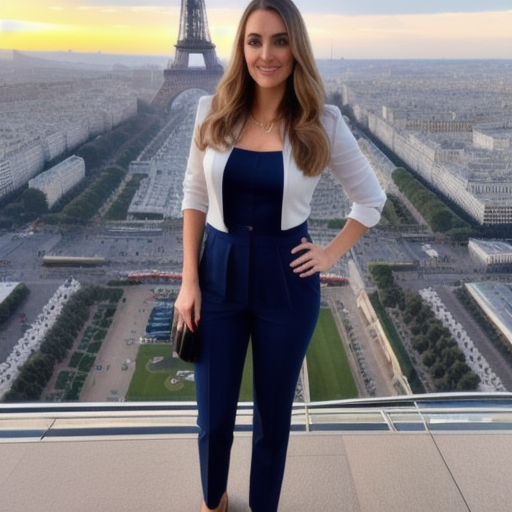

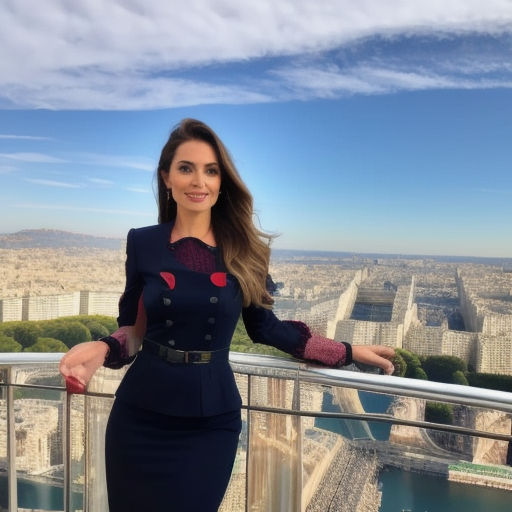

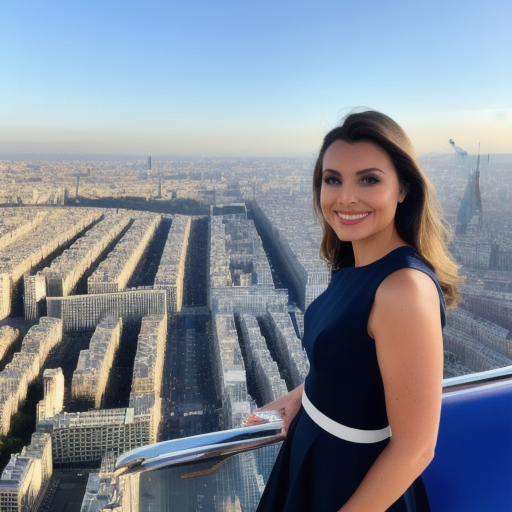

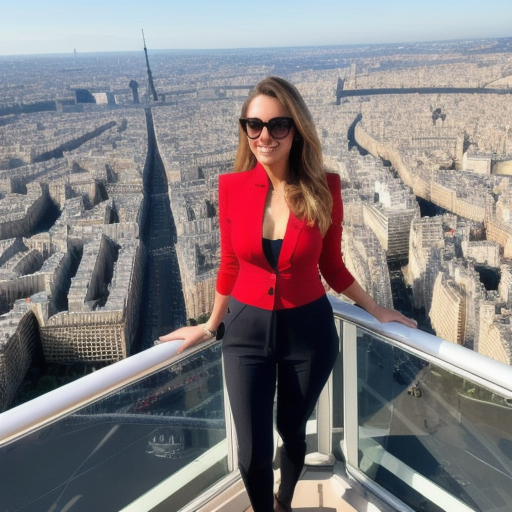

In [3]:
#@title Test image generation from model

prompt = "Photo of Anjalina jolie , standing top of Eiffel Tower, sun lighting, 8k" #@param {type:"string"}
negative_prompt = "disfigured, ugly, bad, immature, cartoon, anime, 3d, painting, b&w , low resolution, deformed eyes" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 25 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 10000 #@param {type:"number"}

%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)
;
from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    from ipywidgets import widgets, HBox
    from IPython.display import display
    for im in images:
        display(im)